In [1]:
# Importing packages

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from scipy import integrate

In [2]:
# Defining function with random Gaussian noise, along with other parameters for FFT

Fs = 300.0; # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(-1,1,Ts) # time vector
y = t**2 # example function whose extrema are to be found
noise = np.random.normal(0,0.1,len(t)) # example Gaussian noise signal

y += noise # example function with noise whose extrema are to be found

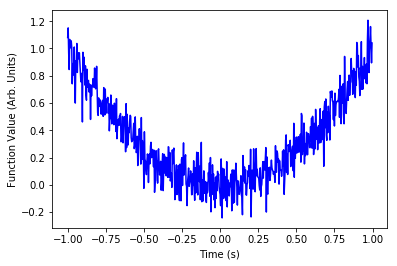

In [3]:
# Plotting function with noise

plt.plot(t,y,'b')
plt.xlabel('Time (s)')
plt.ylabel('Function Value (Arb. Units)')

plt.show()

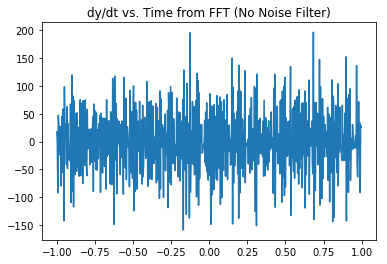

In [4]:
# FFT differentiation

frq = np.fft.fftfreq(t.shape[-1])*Fs # frequency spectra, in standard order (zero, positive, then negative frequencies)

Yk = np.fft.fft(y) # compute Fourier coefficients Yk of function with noise, return array with Fourier coefficients Yk in standard order

Ykprime = [0]*len(Yk) # initialize Ykprime array
Ykprime = (2.0*np.pi*1j)*frq*Yk # compute Fourier coefficients of derivative of function with noise Yk', return array with Fourier coefficients Yk' in standard order
        
yprime = np.real(np.fft.ifft(Ykprime)) # inverse FFT of Ykprime gives derivative of original function with noise in time domain

plt.plot(t,yprime)
plt.title('dy/dt vs. Time from FFT (No Noise Filter)')
plt.show()

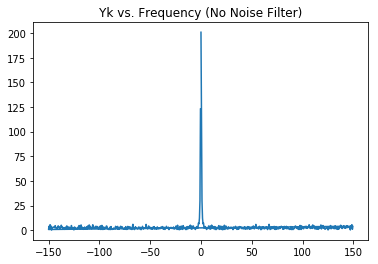

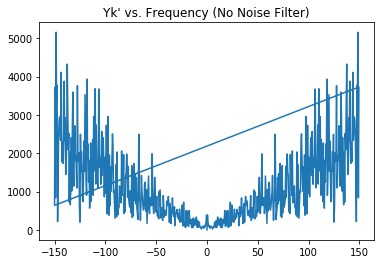

In [5]:
# Plot of Fourier coefficients versus frequency

plt.plot(frq,np.absolute(Yk))
# plt.xlim(-10, 10)
plt.title('Yk vs. Frequency (No Noise Filter)')
plt.show()
plt.plot(frq,np.absolute(Ykprime))
# plt.xlim(-10, 10)
plt.title("Yk' vs. Frequency (No Noise Filter)")
plt.show()

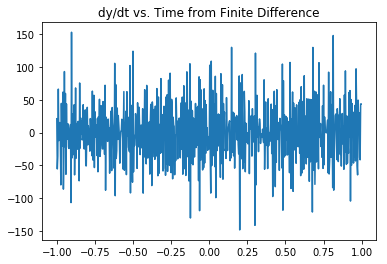

In [6]:
# Finite difference function differentiation, for comparison with FFT differentiation
# Computes derivative by taking difference of adjacent array elements of function, divided by the uniform time spacing

directyprime = [0]*len(y)

directyprime[0:-1] = np.diff(y)/np.diff(t)
directyprime[-1] = (y[-1] - y[-2])/(t[-1] - t[-2])

plt.plot(t,directyprime)
plt.title('dy/dt vs. Time from Finite Difference')
plt.show()

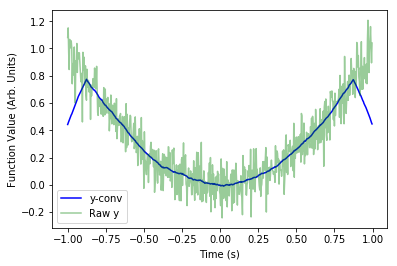

In [7]:
# Filter out Gaussian noise by performing convolution to average over nearest_neighbors nearest neighbors
# This type of filtering is sometimes called a box filter

nearest_neighbors = 75

top_hat_function = np.ones(nearest_neighbors)*1.0/nearest_neighbors
y_conv = np.convolve(y,top_hat_function, 'same')

plt.plot(t,y_conv,'b', label = "y-conv")
plt.plot(t,y,'g', label = "Raw y", alpha = 0.4)
plt.xlabel('Time (s)')
plt.ylabel('Function Value (Arb. Units)')
plt.legend()
plt.show()

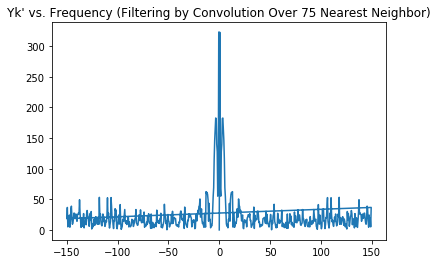

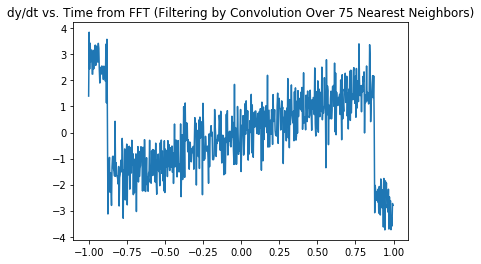

In [8]:
# FFT of filtered function (filtering by box filter)

Ykconv = np.fft.fft(y_conv) # compute Fourier coefficients Ykconv of filtered function, return array with Fourier coefficients Ykconv in standard order

Ykprimeconv = [0]*len(Ykconv) # initialize Ykprimeconv array
Ykprimeconv = (2.0*np.pi*1j)*frq*Ykconv # compute Fourier coefficients of derivative of filtered function Yk'_conv, return array with Fourier coefficients Yk'_conv in standard order

plt.plot(frq,np.absolute(Ykprimeconv))
plt.title("Yk' vs. Frequency (Filtering by Convolution Over %d Nearest Neighbor)" % nearest_neighbors)
# plt.xlim(-50, 50)
plt.show()

yprimeconv = np.real(np.fft.ifft(Ykprimeconv)) # inverse FFT of Ykprime gives derivative of original function with noise in time domain

plt.plot(t,yprimeconv)
plt.title('dy/dt vs. Time from FFT (Filtering by Convolution Over %d Nearest Neighbors)' % nearest_neighbors)
# plt.xlim(-0.85, 0.85)
plt.show()

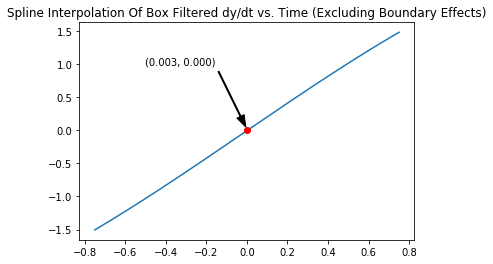

In [9]:
# Find zeros of box filtered dy/dt to find extrema

# Excluding boundary effects due to how np.convolve handles averaging at boundaries
left_boundary = -0.75
right_boundary = 0.75

index_left_boundary = np.argmin(np.abs(t - left_boundary))
index_right_boundary = np.argmin(np.abs(t - right_boundary))

t_exclude_boundary_effects = t[index_left_boundary:index_right_boundary+1]
yprimeconv_exclude_boundary_effects = yprimeconv[index_left_boundary:index_right_boundary+1]

spl_conv = UnivariateSpline(t_exclude_boundary_effects, yprimeconv_exclude_boundary_effects)
interpolatedroots_conv = spl_conv.roots()

plt.plot(t_exclude_boundary_effects, spl_conv(t_exclude_boundary_effects))
plt.plot(interpolatedroots_conv, spl_conv(interpolatedroots_conv), 'or')
plt.annotate('(%0.3f, %0.3f)' % (interpolatedroots_conv, spl_conv(interpolatedroots_conv)), xy=(interpolatedroots_conv, spl_conv(interpolatedroots_conv)), xytext=(-0.5, 1),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.title("Spline Interpolation Of Box Filtered dy/dt vs. Time (Excluding Boundary Effects)")
plt.show()

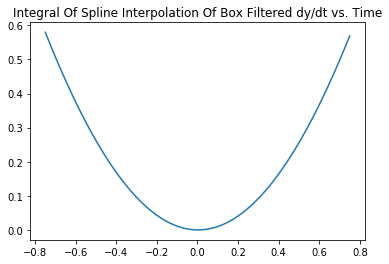

In [10]:
# Integrate spline interpolation of box filtered dy/dt to get box filtered y

spline_y_conv = [0]*len(t_exclude_boundary_effects)

for i,val in enumerate(t_exclude_boundary_effects):
    inty,err = integrate.quad(spl_conv, 0, val)
    spline_y_conv[i] = inty   
    
plt.plot(t_exclude_boundary_effects, spline_y_conv)
plt.title("Integral Of Spline Interpolation Of Box Filtered dy/dt vs. Time")
plt.show()

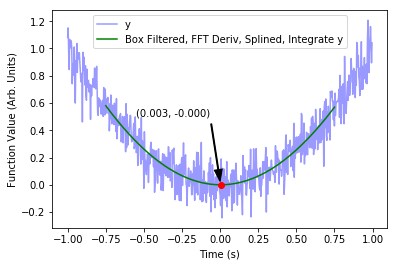

In [11]:
# Plotting function with noise, labeling estimated extremal point from box filter (excluding boundary effects)

estimated_t_extrema_conv = t_exclude_boundary_effects[np.abs(t_exclude_boundary_effects-interpolatedroots_conv).argmin()]
estimated_y_extrema_conv = spline_y_conv[np.abs(t_exclude_boundary_effects-interpolatedroots_conv).argmin()]


# Code that could be useful for multiple extremal points
# estimated_t_extrema_conv = [0]*len(interpolatedroots_conv)
# estimated_y_extrema_conv = [0]*len(interpolatedroots_conv)

# for i in range(0,len(interpolatedroots_conv)):
#    estimated_t_extrema_conv[i] = t_exclude_boundary_effects[np.abs(t_exclude_boundary_effects-interpolatedroots_conv[i]).argmin()]
#    estimated_y_extrema_conv[i] = spline_y_conv[np.abs(t_exclude_boundary_effects-interpolatedroots_conv[i]).argmin()]


plt.plot(t,y,'b',alpha = 0.4,label="y")
plt.plot(t_exclude_boundary_effects, spline_y_conv,'g',label="Box Filtered, FFT Deriv, Splined, Integrate y")
plt.plot(estimated_t_extrema_conv, estimated_y_extrema_conv, 'or')
plt.annotate('(%0.3f, %0.3f)' % (estimated_t_extrema_conv,estimated_y_extrema_conv), xy=(estimated_t_extrema_conv,estimated_y_extrema_conv), xytext=(-0.55, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.xlabel('Time (s)')
plt.ylabel('Function Value (Arb. Units)')

plt.legend()
plt.show()

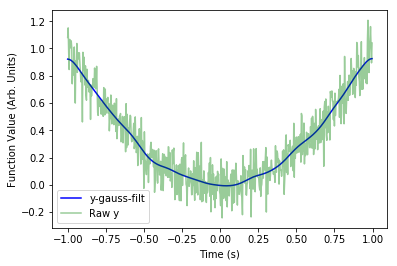

In [12]:
# Filter out Gaussian noise by using a Gaussian filter

gauss_filt_std = 15 # adjusting this affects number of nearest neighbors that are averaged over in smoothing

y_gauss_filt = gaussian_filter1d(y, gauss_filt_std, cval = 1.0) # cval makes filter output converge to preset value at boundaries

plt.plot(t, y_gauss_filt, 'b', label = "y-gauss-filt")
plt.plot(t, y, 'g', label = "Raw y", alpha = 0.4)
plt.xlabel('Time (s)')
plt.ylabel('Function Value (Arb. Units)')
plt.legend()
plt.show()

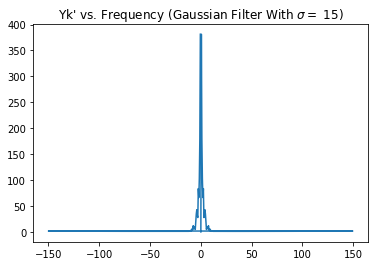

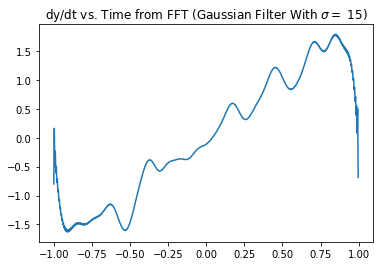

In [13]:
# FFT of filtered function (filtering by Gaussian filter)

Ykgauss = np.fft.fft(y_gauss_filt) # compute Fourier coefficients Ykgauss of filtered function, return array with Fourier coefficients Ykgauss in standard order

Ykprimegauss = [0]*len(Ykgauss) # initialize Ykprimegauss array
Ykprimegauss = (2.0*np.pi*1j)*frq*Ykgauss # compute Fourier coefficients of derivative of filtered function Yk'_gauss, return array with Fourier coefficients Yk'_gauss in standard order

plt.plot(frq,np.absolute(Ykprimegauss))
plt.title("Yk' vs. Frequency (Gaussian Filter With $\sigma =$ %d)" % gauss_filt_std)
# plt.xlim(-20, 20)
plt.show()

yprimegauss = np.real(np.fft.ifft(Ykprimegauss)) # inverse FFT of Ykprime gives derivative of original function with noise in time domain

plt.plot(t,yprimegauss)
plt.title('dy/dt vs. Time from FFT (Gaussian Filter With $\sigma =$ %d)' % gauss_filt_std)
plt.show()

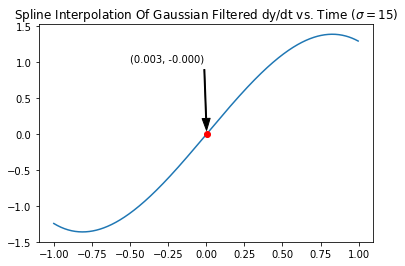

In [14]:
# Find zeros of Gaussian filtered dy/dt to find extrema

spl_gauss = UnivariateSpline(t, yprimegauss)
interpolatedroots_gauss = spl_gauss.roots()

plt.plot(t, spl_gauss(t))
plt.plot(interpolatedroots_gauss, spl_gauss(interpolatedroots_gauss), 'or')
plt.annotate('(%0.3f, %0.3f)' % (interpolatedroots_gauss, spl_gauss(interpolatedroots_gauss)), xy=(interpolatedroots_gauss, spl_gauss(interpolatedroots_gauss)), xytext=(-0.5, 1),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.title("Spline Interpolation Of Gaussian Filtered dy/dt vs. Time ($\sigma =$%d)" % gauss_filt_std)
plt.show()

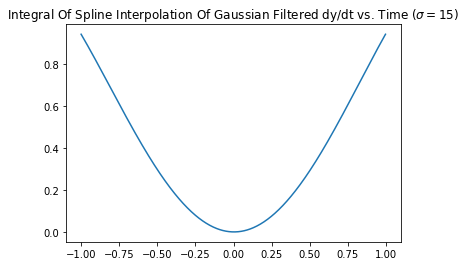

In [15]:
# Integrate spline interpolation of Gaussian filtered dy/dt to get Gaussian filtered y

spline_y_gauss = [0]*len(t)

for i,val in enumerate(t):
    inty,err = integrate.quad(spl_gauss, 0, val)
    spline_y_gauss[i] = inty   
    
plt.plot(t, spline_y_gauss)
plt.title("Integral Of Spline Interpolation Of Gaussian Filtered dy/dt vs. Time ($\sigma =$%d)" % gauss_filt_std)
plt.show()

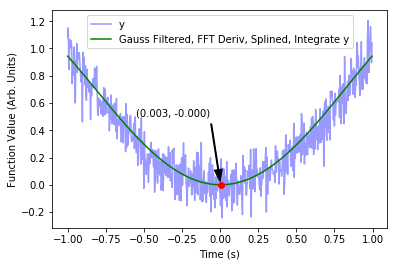

In [16]:
# Plotting function with noise, labeling estimated extremal point from Gaussian filter

estimated_t_extrema_gauss = t[np.abs(t-interpolatedroots_gauss).argmin()]
estimated_y_extrema_gauss = spline_y_gauss[np.abs(t-interpolatedroots_gauss).argmin()]


# Code that could be useful for multiple extremal points
# estimated_t_extrema_gauss = [0]*len(interpolatedroots_gauss)
# estimated_y_extrema_gauss = [0]*len(interpolatedroots_gauss)

# for i in range(0,len(interpolatedroots_gauss)):
#    estimated_t_extrema_gauss[i] = t[np.abs(t-interpolatedroots_gauss[i]).argmin()]
#    estimated_y_extrema_gauss[i] = spline_y_gauss[np.abs(t-interpolatedroots_gauss[i]).argmin()]


plt.plot(t,y,'b',alpha = 0.4,label="y")
plt.plot(t, spline_y_gauss,'g',label="Gauss Filtered, FFT Deriv, Splined, Integrate y")
plt.plot(estimated_t_extrema_gauss, estimated_y_extrema_gauss, 'or')
plt.annotate('(%0.3f, %0.3f)' % (estimated_t_extrema_gauss,estimated_y_extrema_gauss), xy=(estimated_t_extrema_gauss,estimated_y_extrema_gauss), xytext=(-0.55, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.xlabel('Time (s)')
plt.ylabel('Function Value (Arb. Units)')

plt.legend()
plt.show()